 <b><p style="text-align:center;">
    <font size ="6" color ="Black">
        Gangue Forecast in Flotation Concentrate
    </font>
</b>

Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (a.k.a. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. The reverse cationic flotation is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

<p style="text-align:center;">
    <img width="400" alt="Reverse cationic flotation of iron ore" src="https://github.com/ginsaputra/gangue-forecast-in-flotation-concentrate/blob/main/reverse-cationic-flotation-iron-silica.png?raw=true">

Flotation concentrate is periodically sampled to determine its purity (i.e., *%valuable*, *%gangue*). Higher *%gangue* in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This notebook explores the application of deep learning to forecast gangue (*%silica*) in the flotation concentrate. The forecast will help process engineers assess purity of flotation concentrate and take corrective actions in advance. More specifically, the goal is to tackle the following tasks:
- How many steps (hours) ahead can *%silica in concentrate* be forecasted?
- Is it possible to forecast *%silica in concentrate* without using the data of *%iron in concentrate*?

In [25]:
# Install specific library versions

%pip install versioned-hdf5
%pip install h5py==2.10.0
%pip install tensorflow==2.0
%pip install -U numpy==1.18.5

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
time: 15.5 s (started: 2022-02-23 10:50:23 -07:00)


In [26]:
# Load relevant libraries
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy

%matplotlib inline

from IPython.display import HTML, display

# Formatting options
pd.options.display.float_format = '{:,.2f}'.format

# Turn on execution time for JupyterLab
try:
    %reload_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

# ML libraries    
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential, Model, load_model, save_model
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.callbacks import TensorBoard

from tensorflow.python.keras import optimizers
from tensorflow.python.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Plotly libraries
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

# Offline mode
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from IPython.display import HTML, display

# Formatting options
pd.options.display.float_format = '{:,.2f}'.format

time: 0 ns (started: 2022-02-23 10:50:39 -07:00)


# Flotation Data

The dataset was obtained from a mineral processing plant separating silica from iron ore using the reverse cationic flotation method. Continuous process data were collected from 1 a.m. on March 10, 2017 to 11 p.m. on September 9, 2017.

Each row of data consists of 23 measurements that can be categorized into four types:
- raw materials (column 2-3);
- environment variables (column 4-8);
- process variables (column 9-22);
- processed materials (column 23-24).

Raw materials and processed materials were sampled on an hourly basis while the others were sampled every 20 second.

In [27]:
file = r'C:/Users/pdudar/anaconda3/git/MiningProcessData/MiningProcess_Flotation_Plant_Database.csv'
cols_renamed = [
    'date',          # Timestamp of measurements, formatted YYYY-MM-DD HH:MM:SS
    'feed_iron',     # %Iron (valuables) in the ore being fed into the flotation cell
    'feed_silica',   # %Silica (gangue) in the ore being fed into the cell
    'starch_flow',   # Amount of starch (reagent) added into the cell, measured in m^3/h
    'amina_flow',    # Amount of amina (reagent) added into the cell, measured in m^3/h
    'pulp_flow',     # Amount of ore pulp fed into the cell, measured in tonnes/hour
    'pulp_ph',       # Acidity/alkalinity of ore pulp on a scale of 0-14
    'pulp_density',  # Amount of ore in the pulp, between 1-3 kg/cm^3
    'air_col1',      # Volume of air injected into the cell, measured in Nm3/h
    'air_col2',
    'air_col3',
    'air_col4',
    'air_col5',
    'air_col6',
    'air_col7',
    'level_col1',    # Froth height in the cell, measured in mm
    'level_col2',
    'level_col3',
    'level_col4',
    'level_col5',
    'level_col6',
    'level_col7',
    'conc_iron',     # Lab measurement: %Iron in the end of flotation process
    'conc_silica']   # Lab measurement: %Silica in the end of flotation process

df = pd.read_csv(
                file,
                header=0,
                names=cols_renamed,
                parse_dates=['date'],
                infer_datetime_format=True,
                decimal=',')

# Add title columns and make columns upper case
df.columns = df.columns.str.upper()

df['IRON_FEED_TITLE'] = 'IRON FEED'
df['SILICA_FEED_TITLE'] = 'SILICA FEED'
df['CONC_IRON_TITLE'] = 'IRON CONC'
df['CONC_SILICA_TITLE'] = 'SILICA CONC'

cols = df.columns[df.dtypes.eq('float64')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', downcast='float')
      
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DATE               737453 non-null  datetime64[ns]
 1   FEED_IRON          737453 non-null  float32       
 2   FEED_SILICA        737453 non-null  float32       
 3   STARCH_FLOW        737453 non-null  float32       
 4   AMINA_FLOW         737453 non-null  float32       
 5   PULP_FLOW          737453 non-null  float32       
 6   PULP_PH            737453 non-null  float32       
 7   PULP_DENSITY       737453 non-null  float32       
 8   AIR_COL1           737453 non-null  float32       
 9   AIR_COL2           737453 non-null  float32       
 10  AIR_COL3           737453 non-null  float32       
 11  AIR_COL4           737453 non-null  float32       
 12  AIR_COL5           737453 non-null  float32       
 13  AIR_COL6           737453 non-null  float32 

In [28]:
string_cols = list(df.columns[df.dtypes.eq('object')])
string_cols

['IRON_FEED_TITLE',
 'SILICA_FEED_TITLE',
 'CONC_IRON_TITLE',
 'CONC_SILICA_TITLE']

time: 0 ns (started: 2022-02-23 10:50:42 -07:00)


# Preprocessing Time-Series Data

Column `DATE` is resampled to reduce the frequency of our time-series data into an hourly basis. This is achieved by selecting only the first measurements of each hour.

In [29]:
# Resample data to hourly basis
df = df.set_index('DATE').resample('H').first()
df.shape

(4415, 27)

time: 344 ms (started: 2022-02-23 10:50:42 -07:00)


Upon inspecting the data, 318 rows containing missing values are found between `2017-03-16 06:00` to `2017-03-29 11:00`. Missing values introduce discontinuity in the time-series data and can be detrimental to our forecast. Therefore, only the data starting from `2017-03-29 12:00` will be further used.

In [30]:
# Check for missing values
nans = df[df.isna().any(axis=1)]  
print(f'Total rows with NaNs: {nans.shape[0]}\n')

Total rows with NaNs: 318

time: 16 ms (started: 2022-02-23 10:50:43 -07:00)


In [31]:
# Remove data with time discontinuity
df = df['2017-03-29 12:00:00':]
df

,FEED_IRON,FEED_SILICA,STARCH_FLOW,AMINA_FLOW,PULP_FLOW,PULP_PH,PULP_DENSITY,AIR_COL1,AIR_COL2,AIR_COL3,...,LEVEL_COL4,LEVEL_COL5,LEVEL_COL6,LEVEL_COL7,CONC_IRON,CONC_SILICA,IRON_FEED_TITLE,SILICA_FEED_TITLE,CONC_IRON_TITLE,CONC_SILICA_TITLE
DATE,,,,,,,,,,,,,,,,,,,,,
2017-03-29 12:00:00,60.18,9.34,"2,044.99",349.91,405.62,9.75,1.65,200.39,195.73,201.83,...,428.43,413.66,447.89,464.87,66.44,1.36,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-03-29 13:00:00,60.18,9.34,"2,510.36",306.64,402.30,9.64,1.52,200.16,194.29,201.93,...,447.54,421.28,446.70,413.32,66.57,1.43,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-03-29 14:00:00,60.18,9.34,"2,138.23",435.20,401.95,9.61,1.59,199.54,197.44,198.60,...,470.64,455.34,457.39,456.48,66.64,1.33,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-03-29 15:00:00,60.18,9.34,458.08,476.88,400.17,9.75,1.64,199.95,191.46,199.26,...,438.03,446.86,423.18,483.16,66.41,1.27,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-03-29 16:00:00,59.54,9.56,145.35,252.09,399.48,9.97,1.52,199.07,182.43,201.25,...,435.29,434.66,452.47,436.86,63.63,5.50,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-09 19:00:00,49.75,23.20,"2,888.06",494.99,376.47,9.28,1.67,317.07,297.75,301.68,...,440.59,481.30,434.70,401.80,65.05,1.65,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-09-09 20:00:00,49.75,23.20,"4,218.57",492.03,378.63,9.16,1.65,302.08,301.35,300.54,...,371.88,594.52,443.69,375.04,64.83,1.71,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC
2017-09-09 21:00:00,49.75,23.20,"3,159.10",520.99,381.47,9.58,1.74,296.06,298.48,299.08,...,395.46,587.85,489.41,504.98,64.29,1.80,IRON FEED,SILICA FEED,IRON CONC,SILICA CONC


time: 15 ms (started: 2022-02-23 10:50:43 -07:00)


The following plot shows mineral content before (i.e., in the feed) and after flotation process (in the concentrate). As can be observed from the figure, the purpose of flotation is to increase recovery of iron mineral while reducing the gangue (silica).

During some periods (e.g., May 13 to June 13), mineral content in the feed was constant but the resulting content in the concentrate fluctuated. This suggests that *%iron* and *%silica in concentrate* are not solely governed by the content of raw materials but other parameters as well (i.e., environment, process variables).

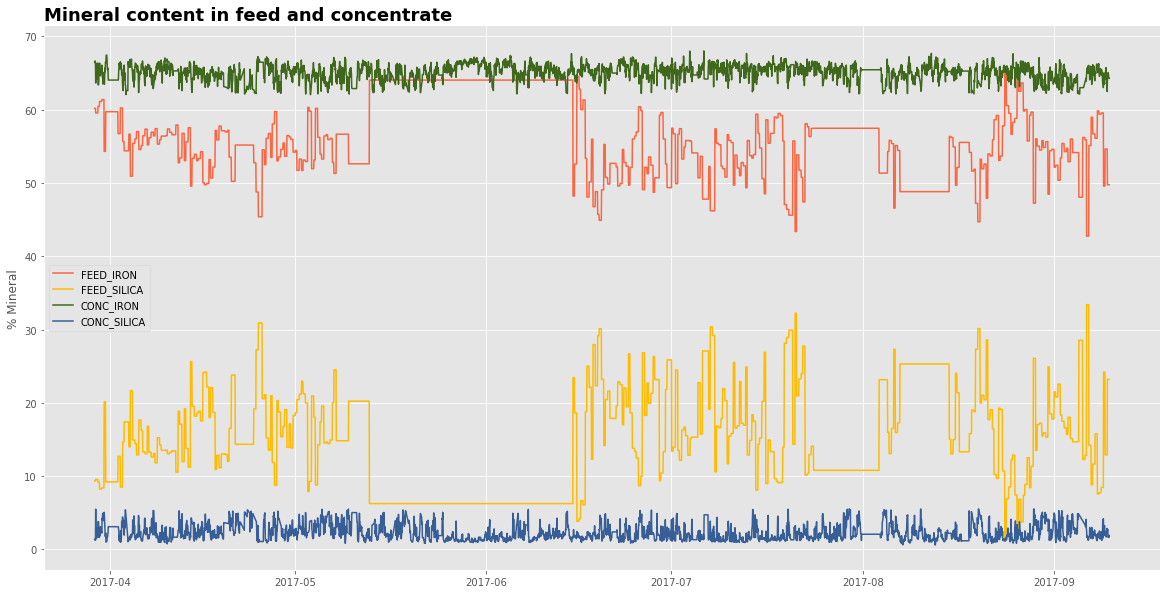

time: 282 ms (started: 2022-02-23 10:50:43 -07:00)


In [32]:
content = ['FEED_IRON', 'FEED_SILICA', 'CONC_IRON', 'CONC_SILICA']
palette = ['#FB6542', '#FFBB00', '#3F681C', '#375E97']

# Plot mineral content before and after flotation
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
for pct, color in zip(content, palette):
    ax.plot(df.index.values, pct, data=df, color=color)
ax.set_title('Mineral content in feed and concentrate',
             loc='left', weight='bold', size=18)
ax.set_ylabel('% Mineral')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center left')
plt.show()

In [33]:
# Create figure with secondary y-axis
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]], shared_yaxes=True)

# Generate a Plotly TimeSeries chart for each monitoring station
fig = px.line(df, 
              x = df.index.values,
              y = 'FEED_IRON',
              title = 'Mineral content in feed and concentrate',
              hover_name = 'IRON_FEED_TITLE', 
              hover_data = ['FEED_IRON'],
               render_mode="webgl")
             
fig2 = px.line(df, 
              x = df.index.values,
              y = 'FEED_SILICA',
              hover_name = 'SILICA_FEED_TITLE', 
              hover_data = ['FEED_SILICA'],
               render_mode="webgl")

fig3 = px.line(df, 
              x = df.index.values,
              y = 'CONC_IRON',
              hover_name = 'CONC_IRON_TITLE', 
              hover_data = ['CONC_IRON'],
               render_mode="webgl")
             
fig4 = px.line(df, 
              x = df.index.values,
              y = 'CONC_SILICA',
              hover_name = 'CONC_SILICA_TITLE', 
              hover_data = ['CONC_SILICA'],
               render_mode="webgl")

fig.update_traces(yaxis="y1")
fig2.update_traces(yaxis="y1")
fig3.update_traces(yaxis="y1")
fig4.update_traces(yaxis="y1")

subfig.add_traces(fig.data + fig2.data + fig3.data + fig4.data)

subfig.layout.xaxis.title="DATE"
subfig.layout.yaxis.title="% MINERAL CONCENTRATION"
subfig.layout.yaxis.type="linear"

#subfig.layout.yaxis2.type="linear"
#subfig.layout.yaxis2.title="UPPER AND LOWER GUIDELINE RECCOMENDATIONS"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color))) 

# Add figure title
subfig.update_layout(title_text = 'Mineral content in feed and concentrate: Time Series with Range Slider')

subfig.update_layout(yaxis=dict(title='% MINERAL CONCENTRATION', tick0=0, anchor='x', rangemode='normal'))
#subfig.update_layout(yaxis2=dict(title='UPPER AND LOWER GUIDELINE RECCOMENDATIONS',
                                # tick0=0, side='right', anchor='x', rangemode='normal'))

# Set y-axes titles
subfig.update_yaxes(title_text="<b>CONCENTRATION</b>", secondary_y=False, autorange=True)

subfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1MNTH", step="month", stepmode="backward"),
            dict(count=6, label="6MNTH", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1YR", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

"""

# Chart options
subfig.update_layout(plot_bgcolor = "RGB(45,45,48)")  #HEX 2d2d30 
subfig.update_layout(paper_bgcolor = "RGB(37,37,38)") #HEX 252526

subfig.update_layout(
    font_color="RGB(131,148,150)",  	#839496
    title_font_color="RGB(131,148,150)",  	#839496
    legend_title_font_color="RGB(131,148,150)") #839496
    
"""

subfig.update_layout(height=600, width=1200)

# Append wq station names to .html files
subfig.write_html("Mineral content in feed and concentrate: Time Series with Range Slider.html", include_plotlyjs='cdn')
subfig.show()

time: 1.25 s (started: 2022-02-23 10:50:43 -07:00)


The column `CONC_IRON` is dropped from the dataframe because we want to look at forecasting *%silica in concentrate* without including *%iron in concentrate* as a feature. The data are then normalized as they have different units and scales.

In [34]:
cols = list(df)
cols.insert(0, cols.pop(         # Moving target `CONC_SILICA` to the front
    cols.index('CONC_SILICA')))  # Not necessary but I prefer to do so
df = df.loc[:, cols]
df.to_csv('./Flotation_Dataset_by_Hour.csv')  # For safekeeping

# Drop `CONC_IRON` then normalize all data
values = df.drop(['CONC_IRON', 'IRON_FEED_TITLE',
                'SILICA_FEED_TITLE',
                'CONC_IRON_TITLE',
                'CONC_SILICA_TITLE'], axis=1).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled[0]  # Show first element of the array

array([0.1541582 , 0.7569444 , 0.2502337 , 0.3251096 , 0.21746036,
       0.6933279 , 0.48318577, 0.3898406 , 0.12485373, 0.09580731,
       0.19501996, 0.14420128, 0.94633675, 0.32903278, 0.31764483,
       0.5680873 , 0.5523838 , 0.6422204 , 0.51514006, 0.4862112 ,
       0.5346519 , 0.5996469 ], dtype=float32)

time: 125 ms (started: 2022-02-23 10:50:45 -07:00)


The preprocessing stage involves framing the dataset as a supervised learning problem where we forecast the *%silica in concentrate* at the current hour (*t*) given the parameters (i.e., raw materials, environment, process) in prior time steps (*t-n*). We transform the dataset using the `series_to_supervised()` function below, which was adapted from the blog [Machine Learning Mastery](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/) by Jason Brownlee.

In [35]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):   # Input sequence (t-n, ... t-1)
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):      # Forecast sequence (t, t+1, ... t+n)
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    agg = pd.concat(cols, axis=1)  # Put it all together
    agg.columns = names
    if dropnan:                    # Drop rows with NaN values
        agg.dropna(inplace=True)
        
    # Drop columns we don't want to predict
    drop_cols = ['var'+str(i)+'(t)' for i in range(2,23)]
    agg.drop(columns=drop_cols, axis=1, inplace=True)   
    return agg

time: 0 ns (started: 2022-02-23 10:50:45 -07:00)


In [36]:
reframed = series_to_supervised(scaled, n_in=1, n_out=1)
reframed  # Show reframed dataset

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var1(t)
1,0.15,0.76,0.25,0.33,0.22,0.69,0.48,0.39,0.12,0.10,...,0.33,0.32,0.57,0.55,0.64,0.52,0.49,0.53,0.60,0.17
2,0.17,0.76,0.25,0.40,0.13,0.61,0.43,0.01,0.12,0.09,...,0.33,0.31,0.99,0.97,0.99,0.55,0.50,0.53,0.49,0.15
3,0.15,0.76,0.25,0.34,0.39,0.61,0.42,0.23,0.12,0.10,...,0.33,0.31,0.98,0.91,1.00,0.60,0.57,0.55,0.58,0.14
4,0.14,0.76,0.25,0.07,0.47,0.56,0.49,0.36,0.12,0.07,...,0.31,0.31,0.99,0.92,1.00,0.53,0.55,0.49,0.64,0.99
5,0.99,0.73,0.26,0.02,0.02,0.55,0.59,0.00,0.12,0.03,...,0.33,0.32,0.99,0.93,1.00,0.53,0.53,0.54,0.54,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3943,0.25,0.30,0.68,0.49,0.51,0.16,0.33,0.40,0.63,0.68,...,0.61,0.58,0.37,0.49,0.34,0.43,0.57,0.43,0.37,0.21
3944,0.21,0.30,0.68,0.46,0.51,0.00,0.26,0.44,0.72,0.63,...,0.59,0.61,0.60,0.45,0.50,0.54,0.62,0.51,0.47,0.23
3945,0.23,0.30,0.68,0.67,0.50,0.06,0.20,0.39,0.64,0.65,...,0.81,0.84,0.37,0.48,0.28,0.41,0.84,0.53,0.41,0.24
3946,0.24,0.30,0.68,0.50,0.56,0.12,0.40,0.65,0.61,0.64,...,0.89,0.78,0.35,0.52,0.35,0.45,0.83,0.61,0.68,0.28


time: 31 ms (started: 2022-02-23 10:50:45 -07:00)


Column `var1(t-1)` until `var22(t-1)` are our features/inputs. Measured values of the inputs are lagged **1 hour** before the target `var1(t)` (*%silica in concentrate* at time *t*).

Transformed data is further split into three sets: training (60%), validation (20%), and testing (20%). Flotation data in the period between `2017-03-29 12:00` and `2017-08-08 00:00` is used for training/validation purpose, totaling 3157 hours.

In [37]:
n_features = 22             # Number of inputs for forecast
n_hours = 1                 # Number of hours with which to lag features
n_obs = n_hours*n_features

# Define row size of each split
n_train = int(np.round(len(reframed)*.60))
n_valid = int(np.round(len(reframed)*.20))
n_test = int(np.round(len(reframed)*.20))

# Split dataset by row size
values = reframed.values
train = values[:n_train, :]
valid = values[n_train:(n_train+n_valid), :]
test = values[(n_train+n_valid):, :]

# Each set further split into inputs/features (X) and output (y)
train_X, train_y = train[:, :n_obs], train[:, -1]
valid_X, valid_y = valid[:, :n_obs], valid[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]

# Reshape inputs (X) to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
valid_X = valid_X.reshape((valid_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print(  # Show the final shape of each set
    f'Training set  : {train_X.shape}, {train_y.shape}',
    f'\nValidation set: {valid_X.shape}, {valid_y.shape}',
    f'\nTesting set   : {test_X.shape}, {test_y.shape}')

Training set  : (2368, 1, 22), (2368,) 
Validation set: (789, 1, 22), (789,) 
Testing set   : (790, 1, 22), (790,)
time: 0 ns (started: 2022-02-23 10:50:45 -07:00)


# Building and Training Model

Forecasting gangue in flotation concentrate is a time-series related problem. A variation of the recurrent neural networks (RNN), called the long short-term memory (LSTM), is a deep learning approach that can be implemented to solve the problem.
> *LSTMs have an edge over conventional feed-forward neural networks and RNN in many ways. This is because of their property of selectively remembering patterns for long durations of time.* -[Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

Model construction and training is done with [Keras](https://tensorflow.org/api_docs/python/tf/keras), a Python deep learning library. The model is made up of two [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers, each with 16 memory cells, and followed by a fully-connected ([Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) layer. In training, the data are grouped into mini batches of 16 training samples. The training process is run for 100 epochs (one epoch is the number of passes needed to complete the entire training samples).

In [38]:
os.chdir(r'C:/Users/pdudar/anaconda3/git/MiningProcessData/')

model = Sequential([   # Define a sequential model
    LSTM(units=16,
         return_sequences=True,
         input_shape=(train_X.shape[1],
                      train_X.shape[2])),
    LSTM(units=16),
    Dense(1)
])

model.compile(
    loss='mae',        # Mean absolute error
    optimizer='adam')  # Learning rate = 0.001

model.summary()        # Display model's architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 16)             2496      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 4,625
Trainable params: 4,625
Non-trainable params: 0
_________________________________________________________________
time: 485 ms (started: 2022-02-23 10:50:45 -07:00)


In [39]:
# Load tensorboard notebook extension

try: 
    %reload_ext tensorboard
except:   
    %load_ext tensorboard

# Add TensorBoard callback variables
logdir = "/logs/" + datetime.datetime.now().strftime("/%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir, 
                                histogram_freq=1,
                                profile_batch = 100000000)

# Create ModelCheckpoint
model_checkpoint = ModelCheckpoint('./LSTM_Flotation_Gangue.h5')

time: 15 ms (started: 2022-02-23 10:50:46 -07:00)


In [40]:
history = model.fit(   # Fit on training data
    train_X,
    train_y,
    epochs=100,
    batch_size=16,
    validation_data=(  # Supply validation data
        valid_X,
        valid_y),
    verbose=2,
    shuffle=False,
    callbacks=[model_checkpoint])


Train on 2368 samples, validate on 789 samples
Epoch 1/100
2368/2368 - 8s - loss: 0.2143 - val_loss: 0.1528
Epoch 2/100
2368/2368 - 1s - loss: 0.1734 - val_loss: 0.1494
Epoch 3/100
2368/2368 - 1s - loss: 0.1651 - val_loss: 0.1441
Epoch 4/100
2368/2368 - 1s - loss: 0.1486 - val_loss: 0.1356
Epoch 5/100
2368/2368 - 1s - loss: 0.1249 - val_loss: 0.1108
Epoch 6/100
2368/2368 - 1s - loss: 0.1110 - val_loss: 0.1007
Epoch 7/100
2368/2368 - 1s - loss: 0.1064 - val_loss: 0.0962
Epoch 8/100
2368/2368 - 1s - loss: 0.1030 - val_loss: 0.0932
Epoch 9/100
2368/2368 - 1s - loss: 0.1001 - val_loss: 0.0916
Epoch 10/100
2368/2368 - 1s - loss: 0.0983 - val_loss: 0.0905
Epoch 11/100
2368/2368 - 1s - loss: 0.0971 - val_loss: 0.0897
Epoch 12/100
2368/2368 - 1s - loss: 0.0967 - val_loss: 0.0898
Epoch 13/100
2368/2368 - 1s - loss: 0.0971 - val_loss: 0.0914
Epoch 14/100
2368/2368 - 1s - loss: 0.0966 - val_loss: 0.0897
Epoch 15/100
2368/2368 - 1s - loss: 0.0962 - val_loss: 0.0900
Epoch 16/100
2368/2368 - 1s - lo

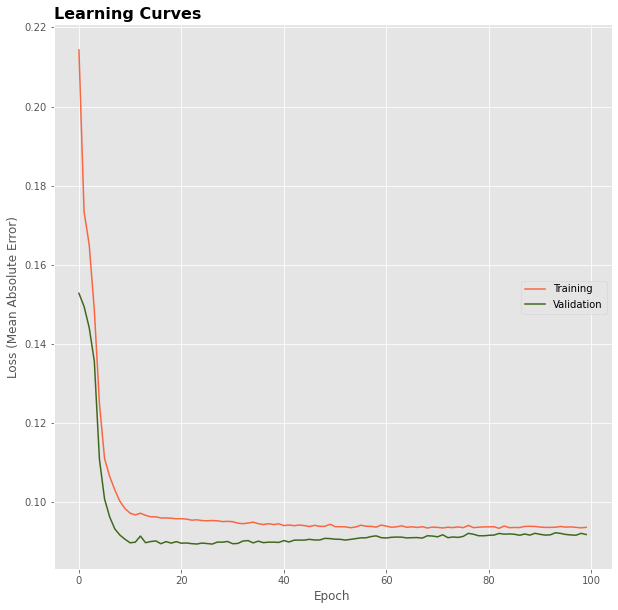

time: 203 ms (started: 2022-02-23 10:52:07 -07:00)


In [41]:

# Extract losses from training history
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

# Plot learning curves
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(train_loss, color=palette[0], label='Training')
ax.plot(valid_loss, color=palette[2], label='Validation')
ax.set_title('Learning Curves', loc='left', weight='bold', size=16)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (Mean Absolute Error)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc='center right')
plt.show()

The plot above indicates that the model exhibits a good fit where training and validation losses decrease to a point of stability and there is minimal gap between the two values.

In [42]:
print(f'Best training loss = {min(train_loss):.4f}',
      f'at epoch {train_loss.index(min(train_loss))}',
      f'\nBest validation loss = {min(valid_loss):.4f}',
      f'at epoch {valid_loss.index(min(valid_loss))}')

Best training loss = 0.0933 at epoch 82 
Best validation loss = 0.0893 at epoch 26
time: 0 ns (started: 2022-02-23 10:52:08 -07:00)


# Forecasting with LSTM

Forecasting is performed using the trained model and on the data that was not included during training/validation process. Forecasts and actual values are inverted back into their original scales before calculating error scores for the model. Two error metrics are considered in the forecast evaluation: (1) mean absolute error, and (2) root mean squared error.

In [43]:
# Make prediction using test features
yhat = model.predict(test_X)

# Reshape test data
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_y = test_y.reshape((len(test_y), 1))

# Invert scaling for forecasts
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual values
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate error scores
mae = mean_absolute_error(inv_y, inv_yhat)
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMean absolute error    : {mae:.4f}',
      f'\nRoot mean squared error: {rmse:.4f}')

--------------------------------
FORECAST EVALUATION
-------------------------------- 
Mean absolute error    : 0.4847 
Root mean squared error: 0.7063
time: 734 ms (started: 2022-02-23 10:52:08 -07:00)


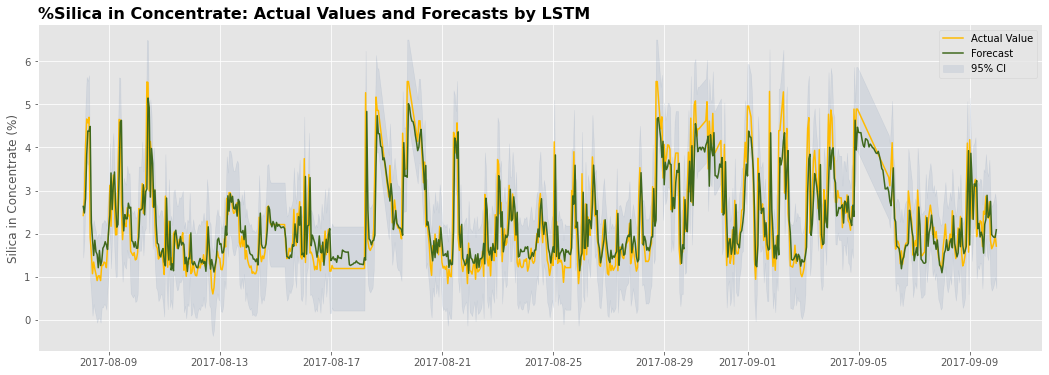

<Figure size 432x288 with 0 Axes>

time: 312 ms (started: 2022-02-23 10:57:31 -07:00)


In [50]:
# Define date as x-axis
test_date = df.index[-test_y.shape[0]:]

# CI 95% (Z-value 1.96)
ci = 1.96*np.std(inv_y) / np.mean(inv_y)

# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(test_date, inv_y, color=palette[1], label='Actual Value')
ax.plot(test_date, inv_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (inv_y-ci), (inv_y+ci), color=palette[3],
                alpha=.1, label='95% CI')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by LSTM',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()
plt.savefig('Silica in Concentrate_Actual Values and Forecasts by LSTM')

In [46]:
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]], shared_yaxes=True)

fig = go.Figure([
    go.Scatter(
        name='% Silica in Concentrate: Actual Value',
        x=test_date,
        y=inv_y,
        mode='lines',
        line=dict(color='rgb(24, 48, 96)',
        width=1)
    ),
    
    go.Scatter(
        name='% Silica in Concentrate: Forecast Value',
        x=test_date,
        y=inv_yhat,
        mode='lines',
        line=dict(color='rgb(48, 96, 192)',
                  width=1)
    ),
    
    go.Scatter(
        name='95% CI: Upper Bound',
        x=test_date,
        y=inv_y+ci,
        mode='lines',
        fill='tonexty',
        showlegend=True
    ),
    
    go.Scatter(
        name='95% CI: Lower Bound',
        x=test_date,
        y=inv_y-ci,
        mode='lines',
        fill='tonexty',
        showlegend=True
    )
])

fig.update_layout(
    yaxis_title='Silica in Concentrate (%)',
    title='% Silica in Concentrate: Actual Values and Forecasts by LSTM',
    hovermode="x",
    height=500, width=1500
)

subfig.add_traces(fig.data)

subfig.layout.xaxis.title="Date"
subfig.layout.yaxis.title="Silica in Concentrate (%)"
subfig.layout.yaxis.type="linear"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color))) 

# Add figure title
subfig.update_layout(title_text = '% Silica in Concentrate: Actual Values and Forecasts by LSTM: Time Series with Range Slider')
subfig.update_layout(yaxis=dict(title='Silica in Concentrate (%)', tick0=0, anchor='x', rangemode='normal'))

# Set y-axes titles
subfig.update_yaxes(title_text="<b>Percent Silica in Concentrate</b>", secondary_y=False, autorange=True)

subfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1MNTH", step="month", stepmode="backward"),
            dict(count=6, label="6MNTH", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1YR", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

subfig.update_layout(height=600, width=1500)

# Append wq station names to .html files
subfig.write_html("Silica in Concentrate_ActualValuesForecastLSTM.html", include_plotlyjs='cdn')
subfig.show()

time: 266 ms (started: 2022-02-23 10:56:13 -07:00)


A comparison of forecasts and actual values of *%silica in concentrate* is displayed above for the period between 1 a.m. August 8, 2017 and 11 p.m. September 9, 2017. The forecasts largely follow the pattern of actual values and contained within the 95% CI.

#### Forecast Comparison with Random Forest
A random forest regressor, in comparison to LSTM, generates greater error and may not perform as well for long-term forecast.

In [47]:
# Drop unneeded columns
rf_values = df.drop(['CONC_IRON', 'IRON_FEED_TITLE',
                    'SILICA_FEED_TITLE',
                    'CONC_IRON_TITLE',
                    'CONC_SILICA_TITLE'], axis=1).values

# Reframe data by lagging features by 1 hour (n_in = 1)
rf_reframed = series_to_supervised(rf_values, n_in=1, n_out=1)

# Define features and target
rf_X = rf_reframed.values[:, :-1]
rf_y = rf_reframed.values[:, -1]

# Split data into train/test sets (80/20)
rf_train_X, rf_test_X, rf_train_y, rf_test_y = train_test_split(
    rf_X, rf_y, test_size=.20, random_state=0, shuffle=False)

# Normalize features
rf_scaler = MinMaxScaler(feature_range=(0,1))
rf_train_X = rf_scaler.fit_transform(rf_train_X)
rf_test_X = rf_scaler.transform(rf_test_X)

# Instantiate regressor
forest = RandomForestRegressor(random_state=1234)

# Fit model on training data
forest.fit(rf_train_X, rf_train_y)

# Make prediction using trained model
rf_yhat = forest.predict(rf_test_X)

# Calculate error scores
rf_mae = mean_absolute_error(rf_test_y, rf_yhat)
rf_rmse = np.sqrt(mean_squared_error(rf_test_y, rf_yhat))
print(32*'-'+'\nFORECAST EVALUATION'+'\n'+32*'-',
      f'\nMean absolute error    : {rf_mae:.4f}',
      f'\nRoot mean squared error: {rf_rmse:.4f}')

--------------------------------
FORECAST EVALUATION
-------------------------------- 
Mean absolute error    : 0.5838 
Root mean squared error: 0.7588
time: 4.28 s (started: 2022-02-23 10:56:14 -07:00)


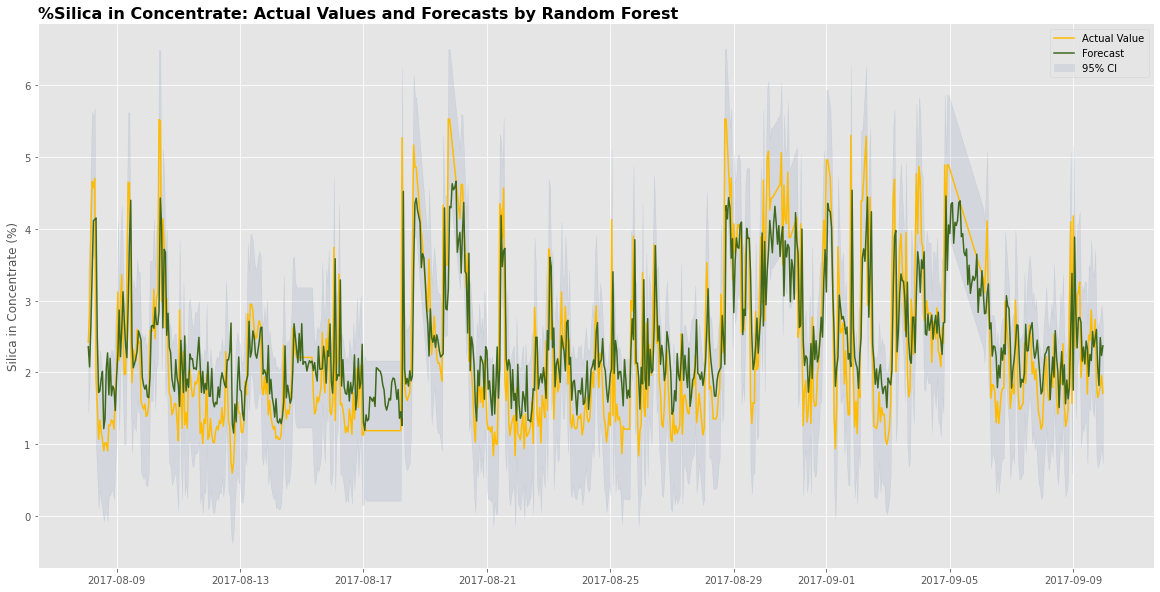

time: 328 ms (started: 2022-02-23 10:56:18 -07:00)


In [48]:
# Plot actual values and forecasts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test_date, rf_test_y, color=palette[1], label='Actual Value')
ax.plot(test_date, rf_yhat, color=palette[2], label='Forecast')
ax.fill_between(test_date, (rf_test_y-ci), (rf_test_y+ci), color=palette[3],
                alpha=.1, label='95% CI')
ax.set_title('%Silica in Concentrate: Actual Values and Forecasts by Random Forest',
             loc='left', weight='bold', size=16)
ax.set_ylabel('Silica in Concentrate (%)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.show()

In [49]:
from plotly.subplots import make_subplots
subfig = make_subplots(specs=[[{"secondary_y": True}]], shared_yaxes=True)

fig = go.Figure([
    go.Scatter(
        name='% Silica in Concentrate: Actual Value',
        x=test_date,
        y=rf_test_y,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)',
                  width=1)
    ),
    
    go.Scatter(
        name='% Silica in Concentrate: Forecast Value',
        x=test_date,
        y=rf_yhat,
        mode='lines',
        line=dict(color='rgb(62, 100, 240)',
                   width=1)
    ),
    
    go.Scatter(
        name='95% CI: Upper Bound',
        x=test_date,
        y=rf_test_y+ci,
        line=dict(width=0),
        mode='lines',
        fill='tonexty',
        showlegend=True
    ),
    
    go.Scatter(
        name='95% CI: Lower Bound',
        x=test_date,
        y=rf_test_y-ci,
        line=dict(width=0),
        mode='lines',
        fill='tonexty',
        showlegend=True
    )
])

fig.update_layout(
    yaxis_title='Silica in Concentrate (%)',
    title='% Silica in Concentrate: Actual Values and Forecasts by Random Forest',
    hovermode="x",
    height=500, width=1500
)

subfig.add_traces(fig.data)

subfig.layout.xaxis.title="Date"
subfig.layout.yaxis.title="Silica in Concentrate (%)"
subfig.layout.yaxis.type="linear"

# recoloring is necessary otherwise lines from fig und fig2 would share each color
# e.g. Linear-, Log- = blue; Linear+, Log+ = red... we don't want this
subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color))) 

# Add figure title
subfig.update_layout(title_text = '% Silica in Concentrate: Actual Values and Forecasts by Random Forest: Time Series with Range Slider')

subfig.update_layout(yaxis=dict(title='Silica in Concentrate (%)', tick0=0, anchor='x', rangemode='normal'))
#subfig.update_layout(yaxis2=dict(title='UPPER AND LOWER GUIDELINE RECCOMENDATIONS',
                                # tick0=0, side='right', anchor='x', rangemode='normal'))

# Set y-axes titles
subfig.update_yaxes(title_text="<b>Silica in Concentrate (%)</b>", secondary_y=False, autorange=True)

subfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1MNTH", step="month", stepmode="backward"),
            dict(count=6, label="6MNTH", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1YR", step="year", stepmode="backward"),
            dict(step="all")
            ])
    )
)

subfig.update_layout(height=600, width=1500)

# Append wq station names to .html files
subfig.write_html("Silica in Concentrate_ActualValuesForecast_RandomForest.html", include_plotlyjs='cdn')
subfig.show()

time: 266 ms (started: 2022-02-23 10:56:18 -07:00)


# Conclusion
A deep learning approach using LSTM was implemented to forecast gangue content in flotation concentrate. Excluding *%iron in concentrate* from the features, *%silica in concentrate* were forecasted one hour ahead and with error below 1 (based on RMSE, MAE). As the dataset owner stated in [this post](https://www.kaggle.com/rogerbellavista/randomforestregressor-mae-0-0922-rmse-0-2314#434654), MAE and RMSE of 1±0.2 is a satisfactory result. The forecasts thus show a promising method for process engineers to make timely assessment of concentrate purity and take corrective actions in advance, especially when purity deviates from the acceptable values.

Finally, although LSTM implementation in this notebook has met the objectives, it will benefit from further exploration:
- Forecasting with smaller lag timesteps. For example, a 30-minute lag for the features/inputs.
- Analysis of feature importance in order to understand which parameters of the flotation process greatly affect *%silica in concentrate*. This ensures that the important parameters are adjusted accordingly.